# Building a classifier


In [1]:
import os
DATA_DIR = '../resources/data/stumbleupon'
raw_path = os.path.abspath(DATA_DIR + '/train.tsv')

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

data_schema = StructType([
    StructField("url", StringType(), True),
    StructField("urlid", StringType(), True),
    StructField("boilerplate", StringType(), True),
    StructField("alchemy_category", StringType(), True),
    StructField("alchemy_category_score", DoubleType(), True),
    StructField("avglinksize", DoubleType(), True),
    StructField("commonlinkratio_1", DoubleType(), True),
    StructField("commonlinkratio_2", DoubleType(), True),
    StructField("commonlinkratio_3", DoubleType(), True),
    StructField("commonlinkratio_4", DoubleType(), True),
    StructField("compression_ratio", DoubleType(), True),
    StructField("embed_ratio", DoubleType(), True),
    StructField("framebased", DoubleType(), True),
    StructField("frameTagRatio", DoubleType(), True),
    StructField("hasDomainLink", DoubleType(), True),
    StructField("html_ratio", DoubleType(), True),
    StructField("image_ratio", DoubleType(), True),
    StructField("is_news", DoubleType(), True),
    StructField("lengthyLinkDomain", DoubleType(), True),
    StructField("linkwordscore", DoubleType(), True),
    StructField("news_front_page", DoubleType(), True),
    StructField("non_markup_alphanum_characters", DoubleType(), True),
    StructField("numberOfLinks", DoubleType(), True),
    StructField("numwords_in_url", DoubleType(), True),
    StructField("parametrizedLinkRatio", DoubleType(), True),
    StructField("spelling_errors_ratio", DoubleType(), True),
    StructField("label", IntegerType(), True)])


In [3]:
rawDf = spark.read.option("delimiter","\t").option("header", True) \
    .csv('file://' + raw_path, schema = data_schema) \
    .na.fill(0.0)

split = 0.7
(trainingDf, testDf) = rawDf.randomSplit([split, 1-split])

## Transformations

In [4]:
excluded_cols = ['url', 'urlid', 'boilerplate', 'alchemy_category', 'alchemy_category_score', 'label']
feature_cols = [item for item in rawDf.columns if item not in excluded_cols]

# Create a features column
from pyspark.ml.feature import VectorAssembler
vec_assembler = VectorAssembler(inputCols = feature_cols, outputCol="features")

# Create a Logistic Regresion model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.0, featuresCol='features', labelCol='label')
lr2 = LogisticRegression(maxIter=10, regParam=0.05, elasticNetParam=0.0, featuresCol='features', labelCol='label')

# Create a liner SVM model
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(maxIter=10, regParam=0.1)

# Create a Naive Bayes model
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# NB doesn't accept negative features
def relu(val):
    return 0.0 if val < 0 else val

from pyspark.sql import functions as f
relu_udf = f.udf(lambda z: relu(z), DoubleType())

trainReLUDf = trainingDf
testReLUDf = testDf
for c in feature_cols:
    trainReLUDf = trainReLUDf.withColumn(c, relu_udf(f.col(c)))
    testReLUDf = testReLUDf.withColumn(c, relu_udf(f.col(c)))

## Training

In [5]:
# Doing it Step by Step

# Vector assembling
trainDfWithFeatures = vec_assembler.transform(trainingDf)
testDfWithFeatures = vec_assembler.transform(testDf)

trainDFWithNBFeatures = vec_assembler.transform(trainReLUDf)
testDFWithNBFeatures = vec_assembler.transform(testReLUDf)

# Training LR
lrModel = lr.fit(trainDfWithFeatures)

# Training SVM
svmModel = svm.fit(trainDfWithFeatures)

# Trainnig NB
nbModel = nb.fit(trainDFWithNBFeatures)

In [6]:
# Alternative approach using pipelines
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vec_assembler, lr2])
pipelineModel = pipeline.fit(trainingDf)

## Evaluating Single Model (Logistic Regresion)

1. True Positive (TP) - label is positive and prediction is also positive
2. True Negative (TN) - label is negative and prediction is also negative
3. False Positive (FP) - label is negative but prediction is positive
4. False Negative (FN) - label is positive but prediction is negative

|  Measure                    |        Description            |         Calculation            | Examples |
|-----------------------------|-------------------------------|--------------------------------|----------|
| **Accuracy**                | Bad for unbalanced dataset    |(TN + TP) / (TN + TP + FN + FP) | - |
| **Precision**               | 100% precision => captured **all TP** with zero FP     | TP / (TP + FP)                 | Spam detection (How many FPs did we catch) |
| **Recall/Sensitivity (TPR)**| 100% sensitivity => captured **all TP** with zero FN <br>(**can potentially have many FP**) | TP / (TP + FN)                 | Fraud detection (How many FNs did we miss) |
| **Specificity (1-FPR)**     | 100% specificity => captured **all TN** with zero FP      | TN / (TN + FP)                 | - |
| **FPR**                     | False Positive Rate  | FP / (TN + FP)                 | - |
| **F measure**               | Harmonic mean of precision and recall | 2 \* (precision \* recall) / (precision + recall) | - |
| **ROC AUC**                 | AUC of TPR (y) vs FPR (x)     |       -           | - |

| AUC ROC | Point Measure (e.g. F1) | Description  |
|---------|---------------|---------|
| Low     | Low           |  Currently bad, and even fitting a threshold will not change it                  |
| Low     | High          |  Currently decent, however for many other values of threshold - it is pretty bad |
| High    | Low           |  Currently bad, however you can find the threshold for which its score is actually pretty decent|
| High    | High          |  Currently decent, and for many other values of threshold it would do the same |

* When you have a data imbalance, always use F1-score because ROC averages over all possible thresholds!
* Raising the classification **threshold**

    * (Probably) **Precision** increased (FPs reduced)
    * (Definitely) **Recall** decreased/constant (TPs reduced, FNs increased, or remain as-is)

Taken from 
* https://stackoverflow.com/a/52892413/3500885
* https://stackoverflow.com/a/34698935/3500885

In [7]:
# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

print("objectiveHistory/ loss:")
for objective in trainingSummary.objectiveHistory:
    print(objective)

trainingSummary.fMeasureByThreshold \
    .join(trainingSummary.precisionByThreshold, 'threshold', 'left') \
    .join(trainingSummary.recallByThreshold, 'threshold', 'left') \
    .show()

# Finding best threshold
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print("bestThreshold: " + str(bestThreshold))

print("roc")
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
lr.setThreshold(bestThreshold)

objectiveHistory/ loss:
0.5643495366101975
0.4984167755310242
0.4939739448418713
0.46881028558172516
0.4521651440827415
0.42704756622410284
0.42609555687176315
0.42191735609851727
0.42182573590787453
0.42177514340155625
0.4217745256866937
+-------------------+-------------------+------------------+--------------------+
|          threshold|          F-Measure|         precision|              recall|
+-------------------+-------------------+------------------+--------------------+
| 0.5222545751816847| 0.3013100436681223|0.5178236397748592| 0.21247113163972287|
| 0.5720923757245537|  0.193138500635324|0.5527272727272727|  0.1170130869899923|
| 0.5957419369422441|0.14943295530353568|              0.56| 0.08622016936104696|
| 0.4716209214243897| 0.4332291201429209|0.5159574468085106| 0.37336412625096227|
| 0.9281288971586317|0.02719033232628399|              0.72|0.013856812933025405|
| 0.3859997284269747| 0.6027308192457738|0.5216657287563309|  0.7136258660508084|
| 0.5089864703453395|0.

LogisticRegression_b89f8918d29b

## Evaluating Pipeline Model (Logistic Regresion)

In [8]:
# Extract the summary from the returned LogisticRegressionModel instance trained
pipelineTrainingSummary = pipelineModel.stages[-1].summary

# Change in regParam
pipelineTrainingSummary.fMeasureByThreshold \
    .join(pipelineTrainingSummary.precisionByThreshold, 'threshold', 'left') \
    .join(pipelineTrainingSummary.recallByThreshold, 'threshold', 'left') \
    .show(5)

# stages of pyspark.ml.Pipeline can be accessed via .getStages()
# stages of pyspark.ml.PipelineModel can be accessed via .stages
pipeline.getStages()[-1].getThreshold()

+-------------------+-------------------+------------------+-------------------+
|          threshold|          F-Measure|         precision|             recall|
+-------------------+-------------------+------------------+-------------------+
| 0.5011812270543475|  0.518800168990283|0.5749063670411985|  0.472671285604311|
|0.45736058505713245| 0.5966174883051457|0.5601351351351351| 0.6381832178598922|
| 0.4935050703497408|  0.533988533988534|0.5704286964129484| 0.5019245573518091|
| 0.6377811603692645|0.21304067140090382|              0.66|0.12702078521939955|
| 0.3327818203426228|  0.679622431982232| 0.531480677377334| 0.9422632794457275|
+-------------------+-------------------+------------------+-------------------+
only showing top 5 rows



0.5

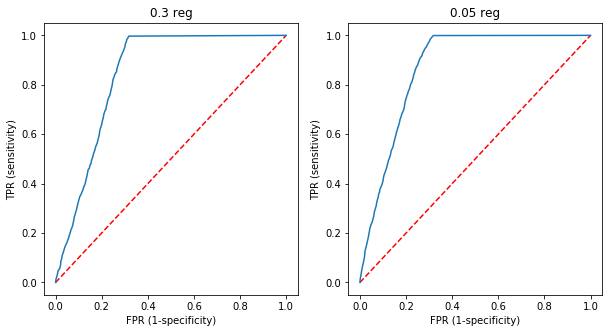

In [10]:
# Plotting ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(), trainingSummary.roc.select('TPR').collect())
plt.title('0.3 reg')
plt.xlabel('FPR (1-specificity)')
plt.ylabel('TPR (sensitivity)')

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(pipelineTrainingSummary.roc.select('FPR').collect(), pipelineTrainingSummary.roc.select('TPR').collect())
plt.title('0.05 reg')
plt.xlabel('FPR (1-specificity)')
plt.ylabel('TPR (sensitivity)')

plt.show()

## Predictions and Evaluations


In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predictions
lr_predictions = lrModel.transform(testDfWithFeatures)
lr_predictions.filter(f.col('url').isNotNull()) \
    .select('url', 'label', 'rawPrediction', 'probability', 'prediction') \
    .show(5)
    
svm_predictions = svmModel.transform(testDfWithFeatures)
nb_predictions = nbModel.transform(testDfWithFeatures)

# MulticlassClassificationEvaluator supports "f1" (default), "precision", "recall", "weightedPrecision", "weightedRecall"
# BinaryClassificationEvaluator supports "f1" (default), "weightedPrecision", "weightedRecall", "accuracy"

e1 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
e2 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderPR')
e3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='f1')
e4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedPrecision')
e5 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedRecall')
e6 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='accuracy')

metricList = []
lr_metrics = ('LR', round(e1.evaluate(lr_predictions), 4), round(e2.evaluate(lr_predictions), 4),
              round(e3.evaluate(lr_predictions), 4), round(e4.evaluate(lr_predictions), 4),
              round(e5.evaluate(lr_predictions), 4), round(e6.evaluate(lr_predictions), 4))
svm_metrics = ('SVM', round(e1.evaluate(svm_predictions), 4), round(e2.evaluate(svm_predictions), 4),
              round(e3.evaluate(svm_predictions), 4), round(e4.evaluate(svm_predictions), 4),
              round(e5.evaluate(svm_predictions), 4), round(e6.evaluate(svm_predictions), 4))
nb_metrics = ('NB', round(e1.evaluate(nb_predictions), 4), round(e2.evaluate(nb_predictions), 4),
              round(e3.evaluate(nb_predictions), 4), round(e4.evaluate(nb_predictions), 4),
              round(e5.evaluate(nb_predictions), 4), round(e6.evaluate(nb_predictions), 4))

metricList.append(lr_metrics)
metricList.append(svm_metrics)
metricList.append(nb_metrics)


metricsDf = spark.createDataFrame(metricList , ["model", "areaUnderROC", "areaUnderPR", "f1", "weightedPrecision", "weightedRecall", "accuracy"])
metricsDf.show()


+--------------------+-----+--------------------+--------------------+----------+
|                 url|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|http://all-that-i...|    1|[0.40222517551390...|[0.59922216484445...|       0.0|
|http://amog.com/g...|    0|[0.14438550346510...|[0.53603379737031...|       0.0|
|http://amysfinert...|    1|[0.43386124191009...|[0.60679531942690...|       0.0|
|http://bakingblon...|    1|[-0.3974878223576...|[0.40191606692039...|       1.0|
|http://bigblackdo...|    1|[0.70756063050975...|[0.66986192444600...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

+-----+------------+-----------+------+-----------------+--------------+--------+
|model|areaUnderROC|areaUnderPR|    f1|weightedPrecision|weightedRecall|accuracy|
+-----+------------+-----------+------+-----------------+--------------+-

## Deep Diving 

In [12]:
# Calculating the statistics of each feature

from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.util import MLUtils

def getSummaryStatistics(df, featureCol='features'):
    mlVectorsDf = df.select(featureCol)
    mllibVectorsDf = MLUtils.convertVectorColumnsFromML(mlVectorsDf)
    mllibVectors = mllibVectorsDf.rdd.map(lambda x: x[featureCol])
    matrix = RowMatrix(mllibVectors)
    return matrix.computeColumnSummaryStatistics()
    
matrixSummary = getSummaryStatistics(trainDfWithFeatures)

In [13]:
print(matrixSummary.min())
print()
print(matrixSummary.max())
print()
print(matrixSummary.numNonzeros())
print()
print(matrixSummary.normL1())
print()
print(matrixSummary.normL2())
print()
print(matrixSummary.mean())
print()
print(matrixSummary.variance())

[ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]

[1.61538462e+02 1.00000000e+00 9.82905983e-01 9.48717949e-01
 9.48717949e-01 2.10000000e+01 2.14285714e-01 0.00000000e+00
 4.21052632e-01 1.00000000e+00 4.66850829e-01 1.70000000e+01
 1.00000000e+00 1.00000000e+00 1.00000000e+02 1.00000000e+00
 8.55990000e+04 3.28300000e+03 2.10000000e+01 1.00000000e+00
 1.00000000e+00]

[2537. 2507. 2433. 2227. 1918. 2525.  279.    0. 2537.   48. 2539. 2531.
 2539. 1851. 2536.  149. 2537. 2539. 2357. 2410. 2520.]

[6.03089179e+03 1.21520426e+03 5.64195669e+02 2.49309121e+02
 1.40998615e+02 3.01703365e+03 1.40614366e+02 0.00000000e+00
 1.46222001e+02 4.80000000e+01 5.88666980e+02 8.03024758e+02
 2.53900000e+03 1.85100000e+03 7.58450000e+04 1.49000000e+02
 1.51161120e+07 4.75855000e+05 1.35410000e+04 4.20016757e+02
 2.45817719e+02]

[2.26916972e+02 2.57887018e+01 1.31342858e+01 6.79036148e+00
 4.66925543e+00 1.95134255e+02 1.17941145e+01 0.00000000e+00
 3.52185893e+0

### Improving Perfomance

### 1. Scaling features

In [14]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerTrainModel = scaler.fit(trainDfWithFeatures)

# This will give us the same mean / std we calculated just now
print(scalerTrainModel.mean)
print()
print(scalerTrainModel.std)

# Normalize each feature to have unit standard deviation.
scaledTrainDf = scalerTrainModel.transform(trainDfWithFeatures)
scaledTestDf = scaler.fit(testDfWithFeatures).transform(testDfWithFeatures)

[1.169230668793525,0.23559601815199696,0.10938264233152387,0.04833445546103142,0.02733590837999226,0.5849231587332302,-0.02663544668514928,0.0,0.028348584828809614,0.009305932531989143,0.11412698334839082,0.11458409426250488,0.49224505622334236,0.35886002326483135,14.704342768514929,0.02888716556804963,2930.6149670414893,92.25571927103528,2.6252423419930198,0.08143015833830944,0.04765756473827065]

[2.9355367690238237,0.271008807331991,0.14657637043476918,0.08126733753517384,0.058993597405134386,2.6535689259634827,0.16206073640594068,0.0,0.04001721443741128,0.09602666235663687,0.11978403456868156,0.588610704965402,0.49998832684627265,0.4797125409637338,20.12587942028342,0.1675056326377111,5965.449036035481,144.8643918017022,3.5117077086568362,0.14100605352473833,0.06146300236247719]


In [15]:
# Checking if scaling works as expected
print(getSummaryStatistics(scaledTrainDf, 'features').mean())
print()
print(getSummaryStatistics(scaledTrainDf, 'scaledFeatures').mean())

[ 1.16923067e+00  2.35596018e-01  1.09382642e-01  4.83344555e-02
  2.73359084e-02  5.84923159e-01 -2.66354467e-02  0.00000000e+00
  2.83485848e-02  9.30593253e-03  1.14126983e-01  1.14584094e-01
  4.92245056e-01  3.58860023e-01  1.47043428e+01  2.88871656e-02
  2.93061497e+03  9.22557193e+01  2.62524234e+00  8.14301583e-02
  4.76575647e-02]

[-7.80625564e-17 -1.66533454e-16 -1.76941795e-16 -2.12503626e-16
 -3.06503954e-16 -7.11236625e-17 -3.29597460e-17  0.00000000e+00
  6.11490025e-17 -7.29125961e-18  1.07552856e-16 -1.73472348e-18
  1.19695920e-16 -9.02056208e-17  7.63278329e-17 -3.46944695e-17
 -1.35308431e-16  1.24900090e-16  2.53269627e-16 -2.84494650e-16
 -8.76035355e-17]


In [16]:
# Re-train using scaledFeatures
from pyspark.ml.classification import LogisticRegression
scaled_lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.0, featuresCol='scaledFeatures', labelCol='label')
scaled_lr_model = scaled_lr.fit(scaledTrainDf)

scaledTrainingSummary = scaled_lr_model.summary

print("objectiveHistory/ loss:")
for objective in scaledTrainingSummary.objectiveHistory:
    print(objective)

scaledTrainingSummary.fMeasureByThreshold \
    .join(scaledTrainingSummary.precisionByThreshold, 'threshold', 'left') \
    .join(scaledTrainingSummary.recallByThreshold, 'threshold', 'left') \
    .show()

# Finding best threshold
fMeasure = scaledTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
print("bestThreshold: " + str(bestThreshold))

print("roc")
scaledTrainingSummary.roc.show()
print("areaUnderROC: " + str(scaledTrainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
scaled_lr.setThreshold(bestThreshold)

objectiveHistory/ loss:
0.5643495366101975
0.43493253400060183
0.43182657253111995
0.4234388343756333
0.42237157802034514
0.4218578729605106
0.4217750274609304
0.4217743979997023
0.42177438396009337
0.4217743800828304
0.42177438004496726
+-------------------+-------------------+------------------+--------------------+
|          threshold|          F-Measure|         precision|              recall|
+-------------------+-------------------+------------------+--------------------+
| 0.3900134570944282| 0.5969756738987508|0.5209409064830751|  0.6989992301770592|
| 0.3470502632757034| 0.6462726462726462|0.5261121856866537|  0.8375673595073133|
| 0.5561403207237344|0.22922983626440266|              0.54| 0.14549653579676675|
|0.37876383821673365| 0.6136218968809675| 0.523060227889311|  0.7421093148575828|
| 0.3678467092096591| 0.6210755362138638|0.5208550573514077|    0.76905311778291|
|0.49536211326898455|0.37837837837837834|0.5230978260869565|  0.2963818321785989|
|0.44423806033661756| 0.

LogisticRegression_d6e241ec4493

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predictions
scaled_lr_predictions = scaled_lr_model.transform(scaledTestDf)

e1 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
e2 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderPR')
e3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='f1')
e4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedPrecision')
e5 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedRecall')
e6 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='accuracy')

scaledMetricList = []
scaled_lr_metrics = ('LR', round(e1.evaluate(scaled_lr_predictions), 4), round(e2.evaluate(scaled_lr_predictions), 4),
              round(e3.evaluate(scaled_lr_predictions), 4), round(e4.evaluate(scaled_lr_predictions), 4),
              round(e5.evaluate(scaled_lr_predictions), 4), round(e6.evaluate(scaled_lr_predictions), 4))

scaledMetricList.append(scaled_lr_metrics)
scaledMetricsDf = spark.createDataFrame(scaledMetricList , ["model", "areaUnderROC", "areaUnderPR", "f1", "weightedPrecision", "weightedRecall", "accuracy"])

metricsDf.show()
scaledMetricsDf.show()

+-----+------------+-----------+------+-----------------+--------------+--------+
|model|areaUnderROC|areaUnderPR|    f1|weightedPrecision|weightedRecall|accuracy|
+-----+------------+-----------+------+-----------------+--------------+--------+
|   LR|      0.8645|     0.5521|0.7462|           0.7491|         0.776|   0.776|
|  SVM|      0.8854|     0.6533|0.8244|           0.8227|         0.827|   0.827|
|   NB|      0.1328|     0.1457|0.7999|              0.8|        0.8131|  0.8131|
+-----+------------+-----------+------+-----------------+--------------+--------+

+-----+------------+-----------+------+-----------------+--------------+--------+
|model|areaUnderROC|areaUnderPR|    f1|weightedPrecision|weightedRecall|accuracy|
+-----+------------+-----------+------+-----------------+--------------+--------+
|   LR|      0.8643|     0.5511|0.7598|           0.7564|        0.7778|  0.7778|
+-----+------------+-----------+------+-----------------+--------------+--------+



### 2. New Features

#### Re-train

In [18]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="alchemy_category", outputCol="alchemy_category_idx", handleInvalid="keep")
encoder = OneHotEncoderEstimator(inputCols=["alchemy_category_idx"],outputCols=["alchemy_category_onehot_vec"])
vec_assembler_2 = VectorAssembler(inputCols = feature_cols + ['alchemy_category_onehot_vec'], outputCol="features")

# Reuse scaler and scaled_lr
pipeline_2 = Pipeline(stages = [indexer, encoder, vec_assembler_2, scaler, scaled_lr])
scaled_lr_model_2 = pipeline_2.fit(trainingDf)

# Finding best threshold

scaledTrainingSummary_2 = scaled_lr_model_2.stages[-1].summary
fMeasure = scaledTrainingSummary_2.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']).select('threshold').head()['threshold']
pipeline_2.getStages()[-1].setThreshold(bestThreshold)

LogisticRegression_d6e241ec4493

#### Prepare test set

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predictions
scaled_lr_predictions_2 = scaled_lr_model_2.transform(testDf)

e1 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderROC')
e2 = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName='areaUnderPR')
e3 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='f1')
e4 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedPrecision')
e5 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='weightedRecall')
e6 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='accuracy')

scaledMetricList2 = []
scaled_lr_metrics_2 = ('LR', round(e1.evaluate(scaled_lr_predictions_2), 4), round(e2.evaluate(scaled_lr_predictions_2), 4),
              round(e3.evaluate(scaled_lr_predictions_2), 4), round(e4.evaluate(scaled_lr_predictions_2), 4),
              round(e5.evaluate(scaled_lr_predictions_2), 4), round(e6.evaluate(scaled_lr_predictions_2), 4))

scaledMetricList2.append(scaled_lr_metrics_2)
scaledMetricsDf2 = spark.createDataFrame(scaledMetricList2 , ["model", "areaUnderROC", "areaUnderPR", "f1", "weightedPrecision", "weightedRecall", "accuracy"])

metricsDf.show()
scaledMetricsDf.show()
scaledMetricsDf2.show()

+-----+------------+-----------+------+-----------------+--------------+--------+
|model|areaUnderROC|areaUnderPR|    f1|weightedPrecision|weightedRecall|accuracy|
+-----+------------+-----------+------+-----------------+--------------+--------+
|   LR|      0.8645|     0.5521|0.7462|           0.7491|         0.776|   0.776|
|  SVM|      0.8854|     0.6533|0.8244|           0.8227|         0.827|   0.827|
|   NB|      0.1328|     0.1457|0.7999|              0.8|        0.8131|  0.8131|
+-----+------------+-----------+------+-----------------+--------------+--------+

+-----+------------+-----------+------+-----------------+--------------+--------+
|model|areaUnderROC|areaUnderPR|    f1|weightedPrecision|weightedRecall|accuracy|
+-----+------------+-----------+------+-----------------+--------------+--------+
|   LR|      0.8643|     0.5511|0.7598|           0.7564|        0.7778|  0.7778|
+-----+------------+-----------+------+-----------------+--------------+--------+

+-----+-------